In [1]:
pip install pandas numpy matplotlib seaborn scikit-learn transformers


Note: you may need to restart the kernel to use updated packages.


In [ ]:
!pip install --upgrade transformers


In [1]:
pip install torch


Note: you may need to restart the kernel to use updated packages.


No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use cpu


 Top 3 Positive Employees (per month):
                          employee_id    month  score
month                                                
2010-01 72      john.arnold@enron.com  2010-01      3
        96    johnny.palmer@enron.com  2010-01      0
        192   rhonda.denton@enron.com  2010-01     -1
2010-02 25     don.baughman@enron.com  2010-02      3
        145   lydia.delgado@enron.com  2010-02      1
...                               ...      ...    ...
2011-11 46     don.baughman@enron.com  2011-11      2
        70        eric.bass@enron.com  2011-11      1
2011-12 71        eric.bass@enron.com  2011-12      5
        95      john.arnold@enron.com  2011-12      2
        191  patti.thompson@enron.com  2011-12      2

[72 rows x 3 columns]

 Top 3 Negative Employees (per month):
                             employee_id    month  score
month                                                   
2010-01 120      kayne.coulter@enron.com  2010-01     -6
        216         sally

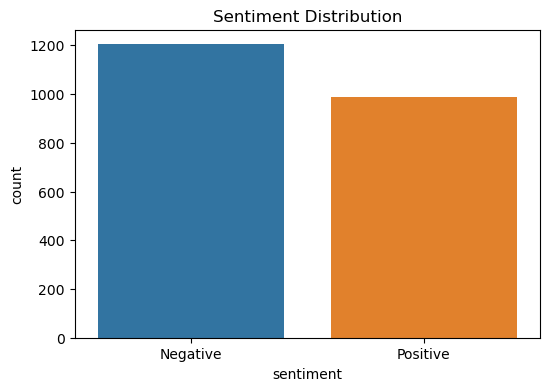

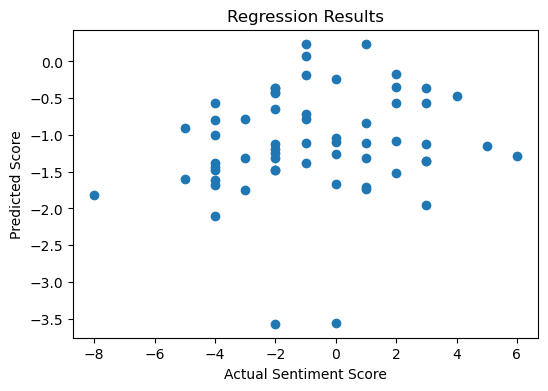

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import pipeline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import os

# Setup
os.makedirs("visualizations", exist_ok=True)

# Load and rename columns
df = pd.read_csv("test.csv")

df.rename(columns={
    'from': 'employee_id',
    'date': 'timestamp',
    'body': 'message'
}, inplace=True)

# Convert dates and fill blanks
df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
df['message'] = df['message'].fillna('')

# Sentiment Labeling
classifier = pipeline("sentiment-analysis")
df['sentiment_raw'] = df['message'].apply(lambda x: classifier(x[:512])[0]['label'])
df['sentiment'] = df['sentiment_raw'].map(lambda x: 'Positive' if x == 'POSITIVE' else 'Negative')

# EDA
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='sentiment')
plt.title("Sentiment Distribution")
plt.savefig("visualizations/sentiment_distribution.png")

# Feature engineering
df['msg_length'] = df['message'].apply(len)
df['word_count'] = df['message'].apply(lambda x: len(x.split()))
df['month'] = df['timestamp'].dt.to_period('M')
df['score'] = df['sentiment'].map({'Positive': 1, 'Negative': -1})

# Monthly scores
monthly_scores = df.groupby(['employee_id', 'month'])['score'].sum().reset_index()

#  Rankings
top3_pos = monthly_scores.groupby('month').apply(lambda x: x.sort_values(['score', 'employee_id'], ascending=[False, True]).head(3))
top3_neg = monthly_scores.groupby('month').apply(lambda x: x.sort_values(['score', 'employee_id']).head(3))

# Flight Risk Detection
df['date'] = df['timestamp'].dt.date
neg_df = df[df['sentiment'] == 'Negative']
flight_risks = set()

for emp_id, group in neg_df.groupby('employee_id'):
    group = group.sort_values('timestamp')
    dates = group['timestamp'].tolist()
    for i in range(len(dates)):
        count = sum([(dates[j] - dates[i]).days <= 30 for j in range(i, len(dates))])
        if count >= 4:
            flight_risks.add(emp_id)
            break

#  Predictive Modeling
features = df.groupby(['employee_id', 'month']).agg({
    'msg_length': 'mean',
    'word_count': 'mean',
    'score': 'sum'
}).reset_index()

X = features[['msg_length', 'word_count']]
y = features['score']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred = lr_model.predict(X_test)

#  Regression Plot
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

plt.figure(figsize=(6, 4))
plt.scatter(y_test, y_pred)
plt.xlabel("Actual Sentiment Score")
plt.ylabel("Predicted Score")
plt.title("Regression Results")
plt.savefig("visualizations/regression_results.png")

#  Final Results
print(" Top 3 Positive Employees (per month):")
print(top3_pos)
print("\n Top 3 Negative Employees (per month):")
print(top3_neg)
print("\n Flight Risk Employees:")
print(flight_risks)
print(f"\n Model Performance:\nMSE = {mse:.2f}, R² = {r2:.2f}")
